# Постановка задачи

Дана линейная граничная задача. Необходимо на равномерной сетке построить для граничной задачи разностную схему второго порядка аппроксимации на минимальном шаблоне и с помощью метода прогонки с шагами $h=0.02$ и $h/2=0.01$ найти численное решение $y^h$ и $y^{h/2}$ соответственно. Проверить выполняются ли достаточные условия корректности и устойчивости метода прогонки. Сравнить найденное численное решение $y^{h/2}$ с точным решением $u(x)$ , т.е. найти $max|u(x_i) - y^{h/2}_i|$. 

В одной системе координат построить график функции $u(x)$ и график полученного численного решения $y^{h/2}$. 

Найти $\frac{1}{3} \cdot max|y^h_i - y^{h/2}_{2i}|$.

### Граничная задача
\begin{cases}
u'' + \frac{3x}{x^2 + 1}u' - \frac{2}{x^2 + 1}u = -\frac{4x^2 + 8}{(x^2 + 1)^3}\\
5u(0.5)=8\\
3u(1) + 2u'(1) = 1
\end{cases}

### Точное решение
$$u(x)=\frac{2}{x^2 + 1}$$

In [1]:
def f(x):
    return -((4 * x ** 2 + 8) / ((x ** 2 + 1) ** 3))


def p(x):
    return (3 * x) / (x ** 2 + 1)


def q(x):
    return -2 / (x ** 2 + 1)


def solution(x):
    return 2 / (x ** 2 + 1)


a, b = 0.5, 1
h, h2 = 0.02, 0.01

<hr>

# Краткая теория, реализация метода

Задача в общем виде:

\begin{cases}
u''(x) + p(x)u'(x) + q(x)u(x) = f(x)\\
u(0.5) = \sigma_0\\
u(1) = \sigma_1y(1)+\mu_1,
\end{cases}

Сетка узлов:

$$w_h = \{ x_i = 0.5 + ih, i=0...N, N = \frac{b - a}{h} \}$$

Разностная схема второго порядка аппроксимации:

\begin{cases}
y_{\overline{x}x}(x) + p(x)y_\overset{\circ}{x}(x) + q(x)y(x) = \varphi(x)\\
y(0) = \mu_0\\
y_\overline{x}(1) = \sigma_1y(1)+\mu_1,
\end{cases}


Индексная форма:

\begin{cases}
\frac{y_{i+1}-2y_i+y_{i-1}}{h^2} + \frac{3x_i}{x_i^2 + 1} \frac{y_{i + 1} - y_{i - 1}}{2h} - \frac{2}{x_i^2 + 1} y_i = -\frac{4x^2_i + 8}{(x_i^2+1)^3}\\
y_0 = \frac{8}{5}\\
\frac{y_N - y_{N - 1}}{h} = (-\frac{3}{2} - \frac{13h}{8})y_N + \frac{1}{2} + \frac{9h}{8}
\end{cases}

Система уравнений (трёхдиагональная матрица):

\begin{cases}
y_{i+1}(\frac{1}{h^2} + \frac{3x_i}{x_i^2 + 1} \frac{1}{2h}) + y_i(\frac{-2}{h^2} - \frac{2}{x_i^2 + 1}) + y_{i - 1}(\frac{1}{h^2} + \frac{3x_i}{x_i^2 + 1} \frac{1}{2h}) = -\frac{4x^2_i + 8}{(x_i^2+1)^3}\\
y_0 = \frac{8}{5}\\
y_N(\frac{1}{h} + \frac{3}{2} + \frac{13h}{8}) + y_{N-1}(\frac{-1}{h}) = \frac{1}{2} + \frac{9h}{8}
\end{cases}

In [2]:
import numpy as np


def get_diagonals(h):
    N = int(round((b - a) / h))
    x = np.linspace(a, b, N + 1)
    b0, c0 = 1, 0
    aN = -1 / h
    bN = 1 / h + 3 / 2 + 13 * h / 8
    
    c_d = np.zeros(N + 1)
    c_d[0] = c0
    for i in range(1, N):
        c_d[i] = 1 / (h ** 2) + p(x[i]) / (2 * h)
    
    b_d = np.zeros(N + 1)
    b_d[0] = b0
    b_d[N] = bN
    for i in range(1, N):
        b_d[i] = -2 / (h ** 2) + q(x[i])

    a_d = np.zeros(N + 1)
    a_d[N] = aN
    for i in range(1, N):
        a_d[i] = 1 / (h ** 2) - p(x[i]) / (2 * h)
    
    return a_d, b_d, c_d


def get_column(h):
    N = int(round((b - a) / h))
    x = np.linspace(a, b, N + 1)
    return np.array([8 / 5, *[f(x[i]) for i in range(1, N)], 1 / 2 + 9 * h / 8])


def get_exact_solution_vector(h):
    N = int(round((b - a) / h))
    x = np.linspace(a, b, N + 1)
    return np.array([solution(x[i]) for i in range(N + 1)])


def solve_tridiagonal_system(diagonals, f):
    n = len(f)
    res = np.zeros(n)

    for i in range(n - 1):
        coef = diagonals[0][i + 1] / diagonals[1][i]
        diagonals[0][i + 1] = 0
        diagonals[1][i + 1] -= coef * diagonals[2][i]
        f[i + 1] -= coef * f[i]

    for i in range(n - 1, 0, -1):
        res[i] = f[i] / diagonals[1][i]
        coef = diagonals[2][i - 1] / diagonals[1][i]
        diagonals[2][i - 1] = 0
        f[i - 1] -= coef * f[i]
        res[0] = f[0] / diagonals[1][0]
    return res


def is_diag_dominant(diagonals):
    return all([abs(b_diag) >= abs(a_diag) + abs(c_diag) for a_diag, b_diag, c_diag in zip(*diagonals)])


def get_solution(h):
    N = int(round((b - a) / h))
    x = np.linspace(a, b, N + 1)
    diagonals = get_diagonals(h)
    f = get_column(h)
    if(is_diag_dominant(diagonals)):
        u = solve_tridiagonal_system(diagonals, f)
        return u
    raise ValueError("Нет диагонального преобладания")


u = get_exact_solution_vector(h2)
y = get_solution(h)
y2 = get_solution(h2)

### Оценка точности метода

In [3]:
np.array(abs(u - y2)).max()

4.6152838664159646e-06

In [4]:
1 / 3 * np.array(abs(y - y2[::2])).max()

4.615511669821733e-06

### График метода сеток рядом с точным решением

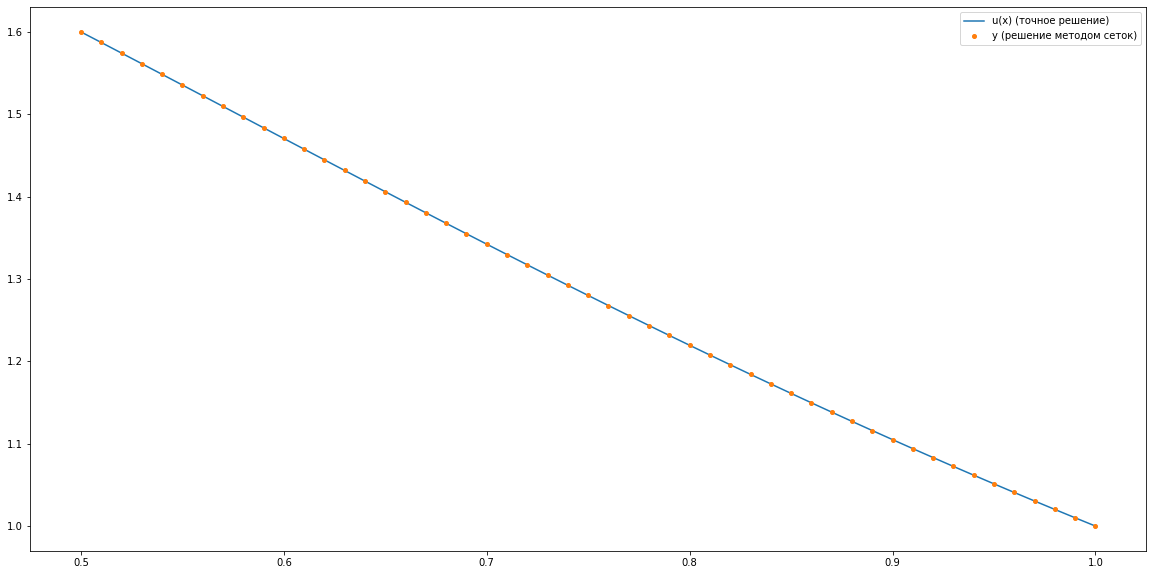

In [5]:
from matplotlib import pyplot as plt


x = np.linspace(a, b, int(round((b - a) / h2)) + 1)
plt.figure(figsize=(20, 10))
plt.plot(x, u, label='u(x) (точное решение)')
plt.plot(x, y2, '.', label='y (решение методом сеток)', markersize=8)
plt.legend()
plt.show()

# Выводы

Метод сеток — достаточно эффективный метод решения обыкновенных дифференциальных уравнений второго порядка, обеспечивающий адекватную точность приближённого решения.